# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [68]:
data = pd.read_csv("Examen.csv")
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [69]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Crear una serie de fechas a partir de enero de 2008, asignándolas a la columna 'Mes'
data['Mes'] = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')

# Mostrar los primeros datos para verificar
print(data.head())

# Guardar el nuevo dataset con la columna de "Mes"
data.to_csv('Examen2.csv', index=False)


         Mes    producto1    producto2
0 2008-01-01  4000.000000  3000.000000
1 2008-02-01  3997.400893  3010.686220
2 2008-03-01  3978.605317  3022.018584
3 2008-04-01  3986.454125  3033.920990
4 2008-05-01  3979.695678  3038.402098


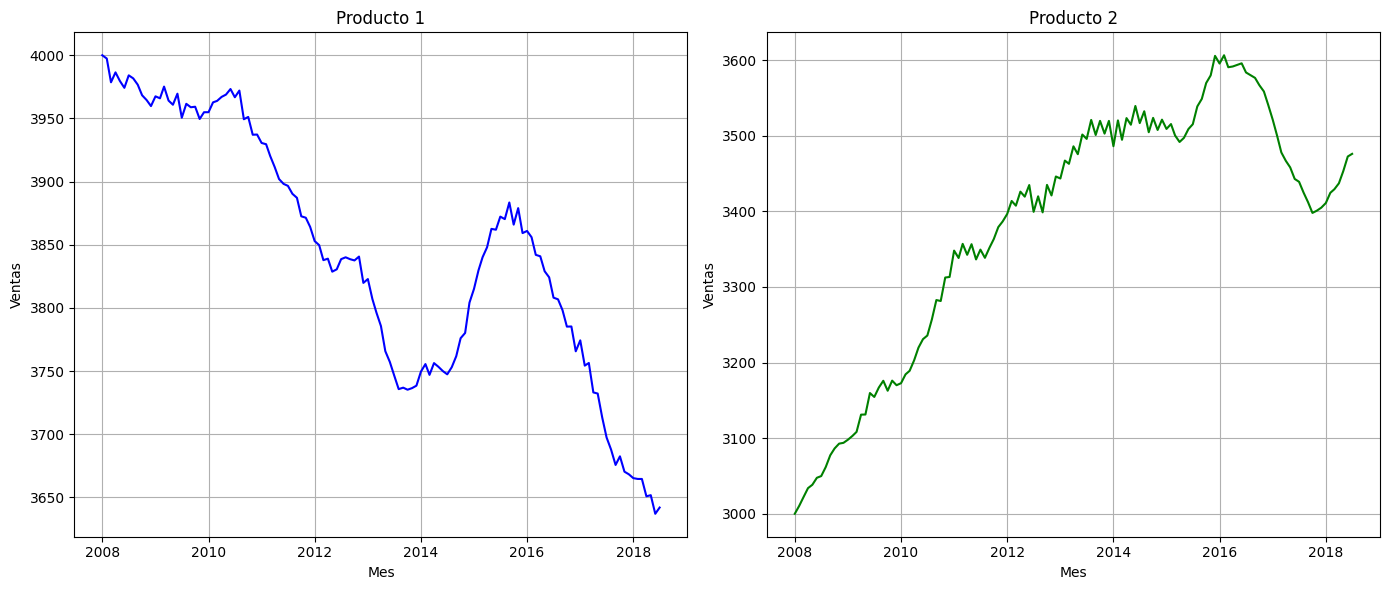

In [70]:
# Convertir la columna 'Mes' a tipo datetime si no lo está
data['Mes'] = pd.to_datetime(data['Mes'])

# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data['Mes'], data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data['Mes'], data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [71]:
product_1_df = data[['producto1']]
product_1_df.index = data['Mes']
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data['Mes']



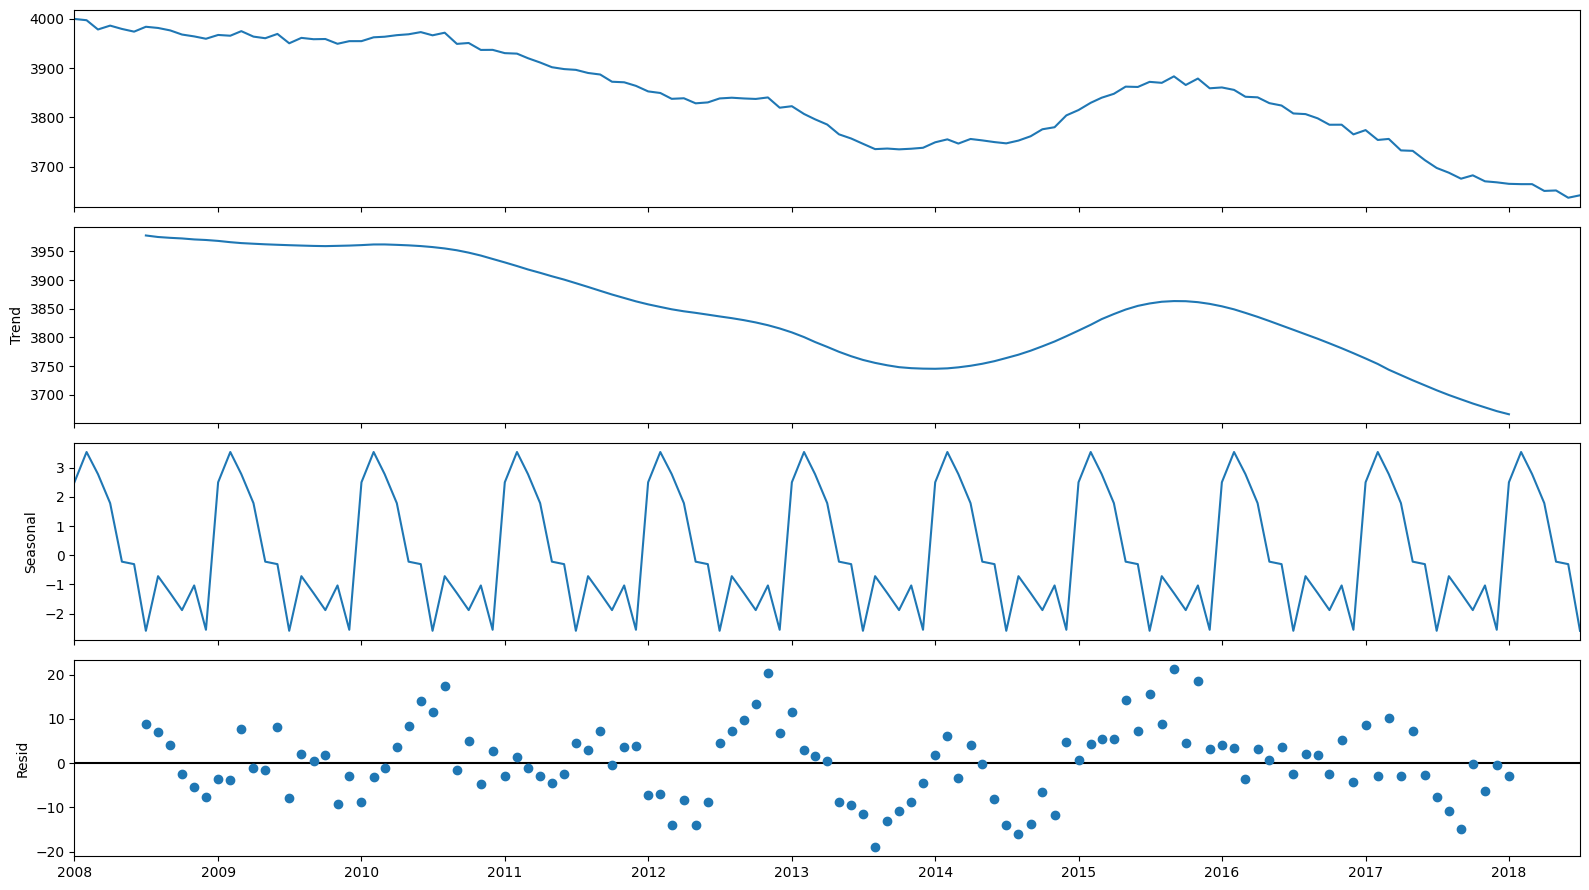

In [72]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

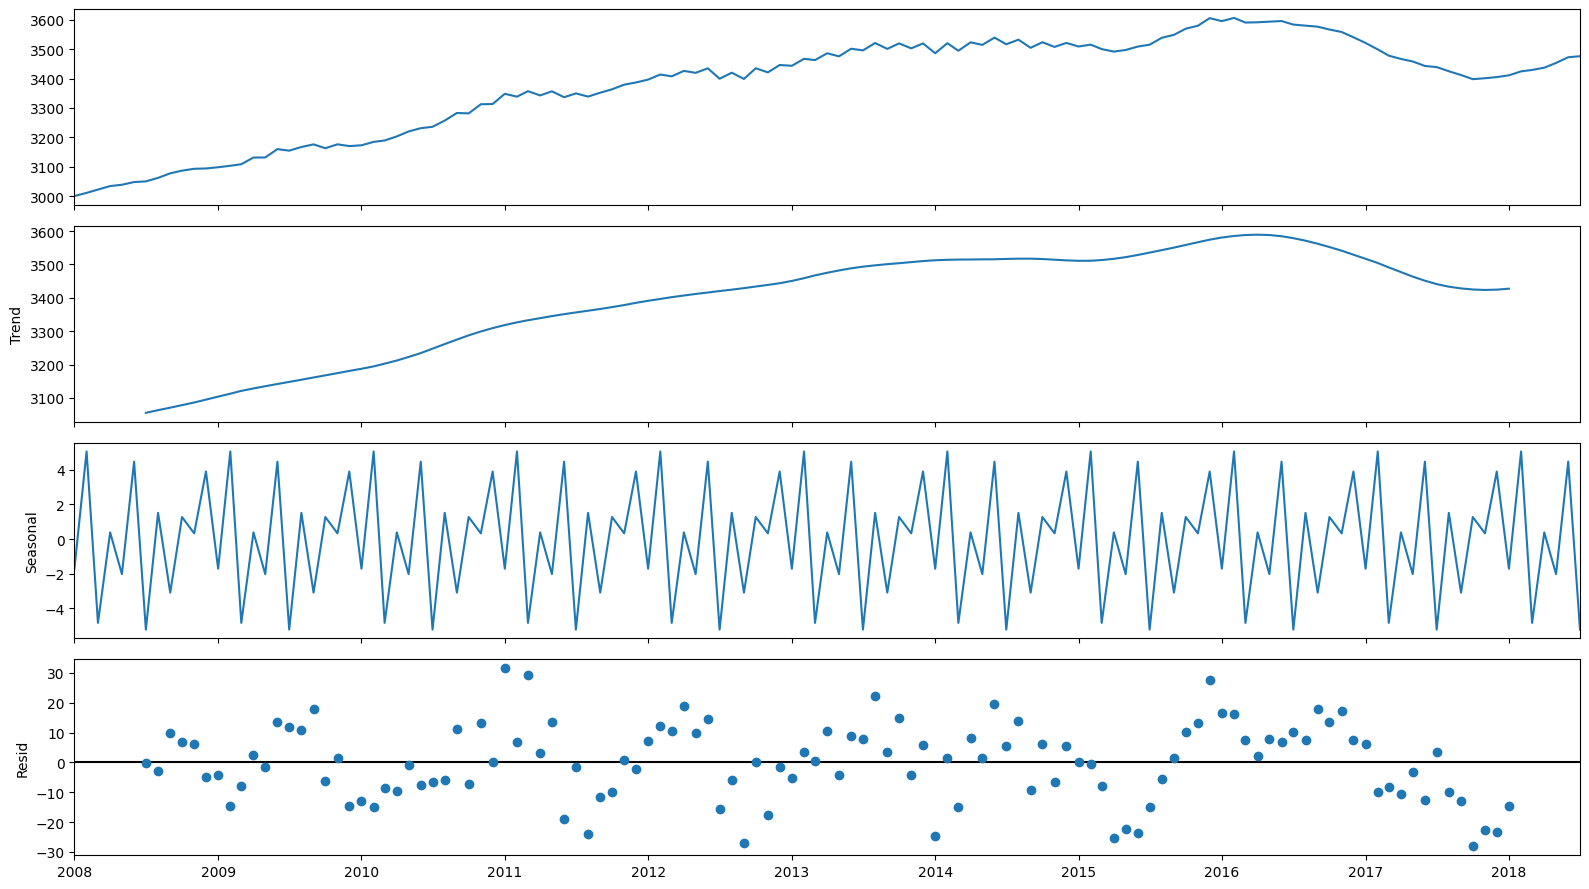

In [73]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [74]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [75]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(
    model_class,
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    init_args=None,
    fit_args=None
):
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    # Ensure init_args and fit_args are dictionaries
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate the model with provided init_args
        model = model_class(y_train, **init_args)

        # Fit the model with fit_args if provided
        model_fit = model.fit(**fit_args)

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [76]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full plot with highlighted forecast section
    ax[0].plot(data.index, data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue', marker='o')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange', marker='o')

    # Adding subtle lines to indicate the delta between actual and forecast
    for i in range(len(forecasts)):
        ax[1].plot([forecast_indices[i], forecast_indices[i]], [data[train_size + i], forecasts[i]], color='red', linestyle='--', linewidth=2)

    ax[1].set_title('Zoomed-In Forecast Section with Delta Lines')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [77]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args={
        'window': 3
	}
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


Promedio móvil RMSE: 9.680204135597737


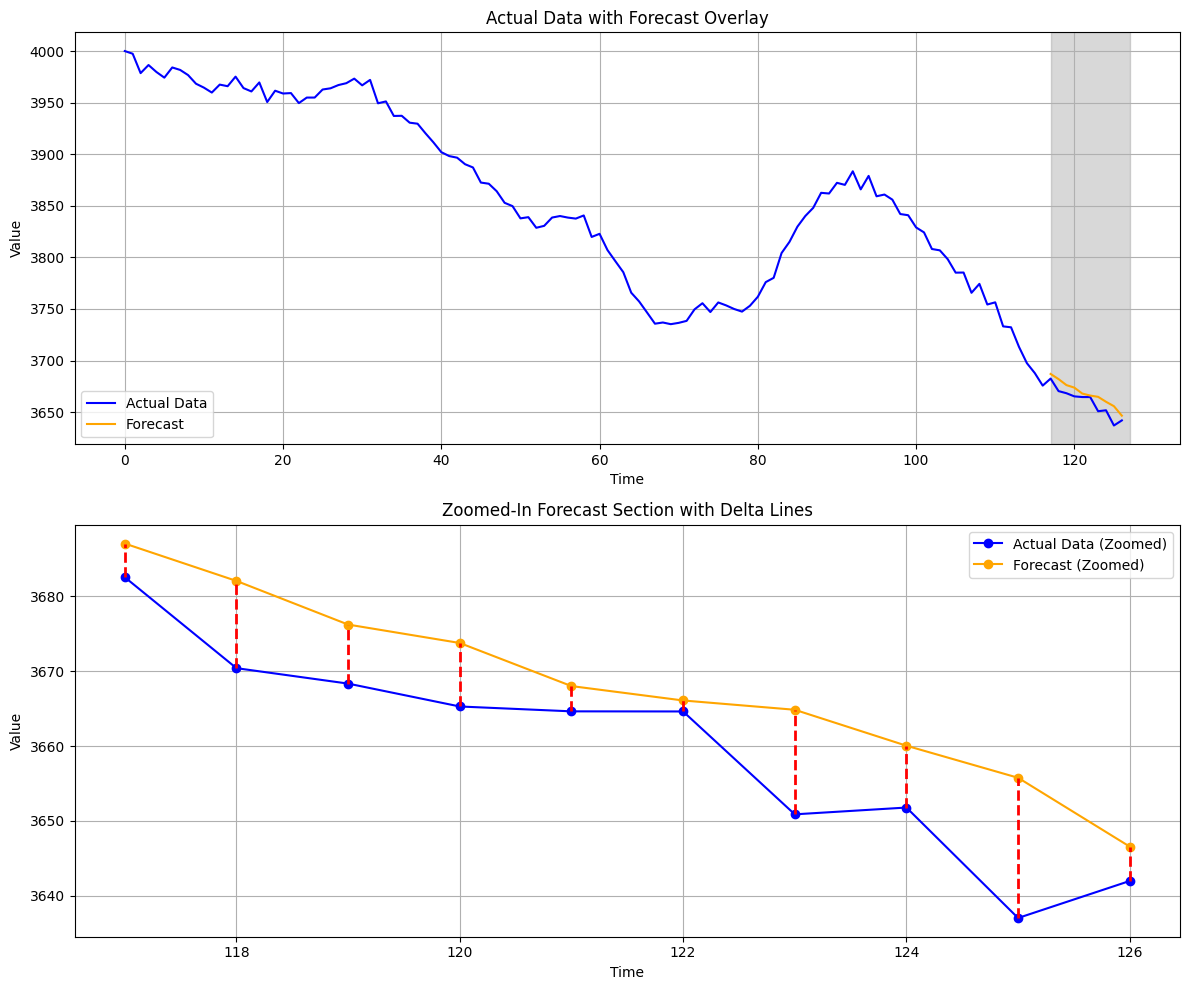

In [78]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [79]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

# Crear el dataset con 'Mes' y 'producto1'
data_producto1 = data[['Mes', 'producto1']].set_index('Mes')

# Crear el dataset con 'Mes' y 'producto2'
data_producto2 = data[['Mes', 'producto2']].set_index('Mes')

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('MS')  # Mes

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('MS')  # Mes

print(data_producto1.head())
print(data_producto2.head())


              producto1
Mes                    
2008-01-01  4000.000000
2008-02-01  3997.400893
2008-03-01  3978.605317
2008-04-01  3986.454125
2008-05-01  3979.695678
              producto2
Mes                    
2008-01-01  3000.000000
2008-02-01  3010.686220
2008-03-01  3022.018584
2008-04-01  3033.920990
2008-05-01  3038.402098


In [80]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):
    """Function we want to maximize (Black box)"""
    
    # Map the parameters (error, trend, seasonal) to actual model components
    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]
    
    # Round and map parameters
    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    init_args = {
        'error': error1[round(error)],
        'trend': trend1[round(trend)],
        'seasonal': seasonal1[round(seasonal)],
    }

    fit_args = {
        'smoothing_level': alpha,
        'smoothing_trend': beta if trend1[round(trend)] else None,
        'smoothing_seasonal': gamma if seasonal1[round(seasonal)] else None
    }
    
    # Use rolling window evaluation
    test_errors, forecasts, _ = rolling_window_evaluation(
        model_class=ETSModel,
        data=data_producto1,
        target_column='producto1',
        initial_train_size=train_size,
        num_iterations=iterations,
        forecast_horizon=horizon,
        init_args=init_args,
        fit_args=fit_args
    )
    
    # Compute the average RMSE over all iterations
    avg_rmse = np.sqrt(np.mean(test_errors))

    print(f"Average RMSE: {avg_rmse}, Error: {error1[round(error)]}, Trend: {trend1[round(trend)]}, Seasonal: {seasonal1[round(seasonal)]}, Alpha: {alpha}, Beta: {beta}, Gamma: {gamma}")

    # Return the negative RMSE for Bayesian Optimization (since it maximizes)
    return -avg_rmse


In [81]:
import warnings
warnings.filterwarnings("ignore")

pbounds = {
    'error':  (0, 1),
    'trend': (0, 2),
    'seasonal': (0, 2),
    'alpha': (0.01, 0.99),
    'beta': (0.01, 0.99),
    'gamma': (0.01, 0.99)
}

optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

optimizer.maximize(
    init_points=10,
    n_iter=50
)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19226D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.80298D+00    |proj g|=  9.26571D-01

At iterate    2    f=  3.71328D+00    |proj g|=  3.52594D-01

At iterate    3    f=  3.69020D+00    |proj g|=  1.05768D-01

At iterate    4    f=  3.68835D+00    |proj g|=  4.05910D-02

At iterate    5    f=  3.68758D+00    |proj g|=  4.04612D-02

At iterate    6    f=  3.68576D+00    |proj g|=  2.06921D-02

At iterate    7    f=  3.68478D+00    |proj g|=  2.21847D-02

At iterate    8    f=  3.68297D+00    |proj g|=  1.35313D-02

At iterate    9    f=  3.67988D+00    |proj g|=  3.60641D-02

At iterate   10 

In [82]:
optimizer.max

{'target': -7.9924154073292994,
 'params': {'alpha': 0.01,
  'beta': 0.99,
  'error': 0.0,
  'gamma': 0.01,
  'seasonal': 2.0,
  'trend': 2.0}}

In [83]:
values_map = {0: None, 1: "add", 2: "mul"}

data_copy = data.copy()
data_copy['Mes'] = pd.to_datetime(data_copy['Mes'])
data_copy = data_copy.set_index('Mes')
data_copy = data_copy.asfreq('MS')

init_args = {
    'error': values_map[round(optimizer.max['params']['error'])],
    'trend': values_map[round(optimizer.max['params']['trend'])],
    'seasonal': values_map[round(optimizer.max['params']['seasonal'])],
}

fit_args = {
    'smoothing_level': optimizer.max['params']['alpha'],
    'smoothing_trend': optimizer.max['params']['beta'] if init_args['trend'] else None,
    'smoothing_seasonal': optimizer.max['params']['gamma'] if init_args['seasonal'] else None
}

filtered_init = {k: v for k, v in init_args.items() if v is not None}
filtered_fit = {k: v for k, v in fit_args.items() if v is not None}

test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19208D+00    |proj g|=  1.02194D+01

At iterate    1    f=  5.19018D+00    |proj g|=  1.73731D+00

At iterate    2    f=  5.08546D+00    |proj g|=  4.21836D+00

At iterate    3    f=  4.94559D+00    |proj g|=  1.12707D+01

At iterate    4    f=  4.59385D+00    |proj g|=  2.48502D+01

At iterate    5    f=  4.22069D+00    |proj g|=  2.29689D+01

At iterate    6    f=  4.04400D+00    |proj g|=  1.94602D+01

At iterate    7    f=  3.80916D+00    |proj g|=  3.55989D+01

At iterate    8    f=  3.67039D+00    |proj g|=  1.40920D+01

At iterate    9    f=  3.64507D+00    |proj g|=  1.04213D+01

At iterate   10    f=  3.61621D+00    |proj g|=  8.61999D+00

At iterate   11    f=  3.60595D+00    |proj g|=  7.37141D+00

At iterate   12    f=  3.60010D+00    |proj g|=  5.43625D+00

At iterate   13    f=  3.5

In [84]:
print(f'Best Model: {best_model}')
print(f'Test Errors: {test_errors}')
print(f'Forecasts: {forecasts}')
# rmse
rmse = np.sqrt(np.mean(test_errors))
print(f'RMSE: {rmse}')

Best Model: <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper object at 0x323445250>
Test Errors: [565.6263394822034, 0.21893964148208717, 1.9137427216948524, 39.44286414211311, 0.004512181173601371, 29.40826883484183, 68.94753355528941, 23.112774097633086, 74.00633165811557, 135.70281184930957]
Forecasts: [3658.7433563279774, 3669.9220913828417, 3666.945044194684, 3671.55495495802, 3664.5582989217273, 3659.187831993206, 3659.185304478574, 3646.9808949818394, 3645.6503326920833, 3630.341717687584]
RMSE: 9.687022856191971


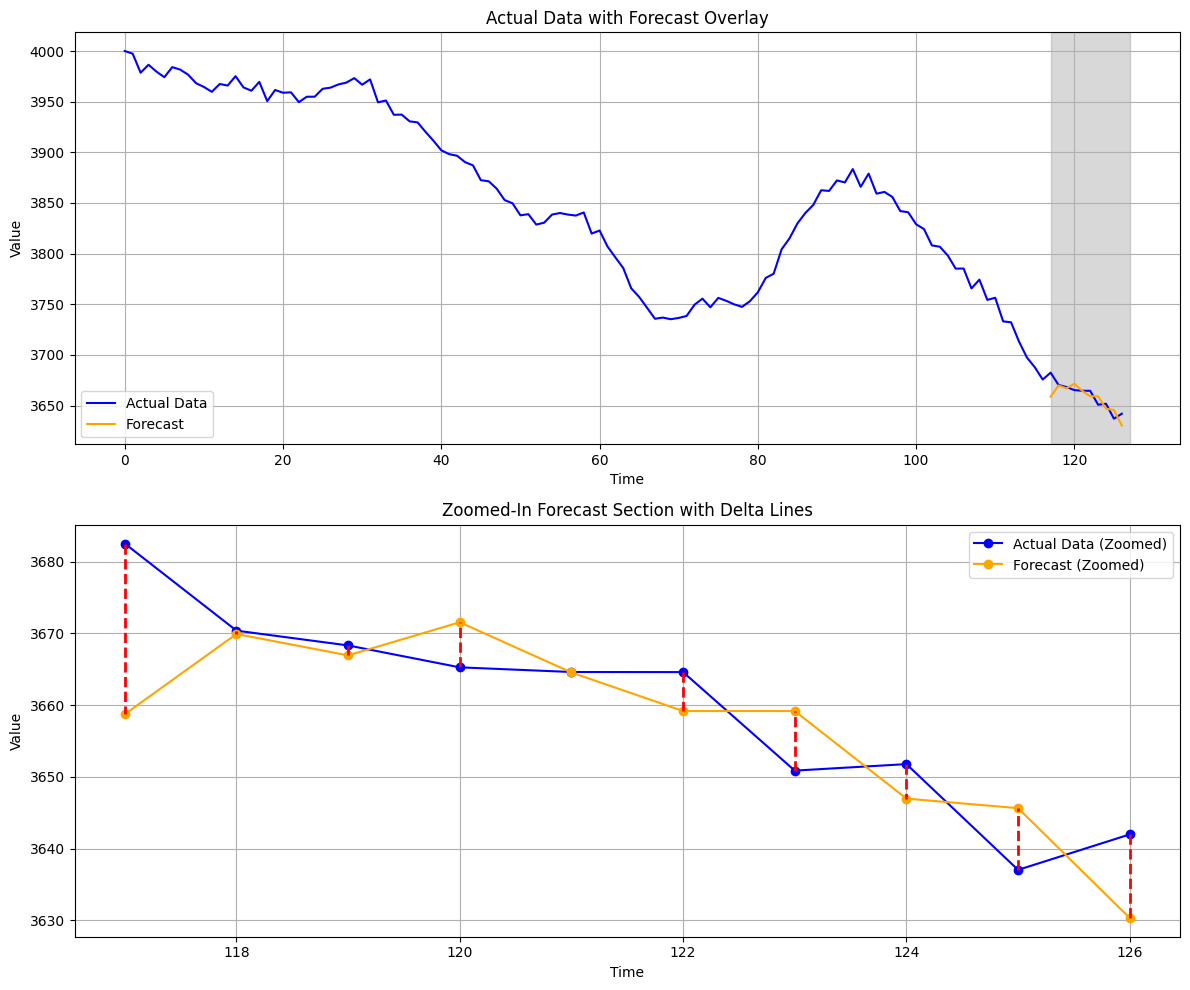

In [85]:
plot_forecast(data['producto1'], forecasts, train_size)

## **5.3 Modelos de Regresión (Tendencia y Estacionalidad)**

Esta función ajusta un modelo de regresión polinómica de un orden especificado sobre un conjunto de datos de entrenamiento. Luego, realiza un pronóstico para un horizonte de tiempo determinado y calcula el RMSE comparando los valores predichos con los valores reales del conjunto de prueba.

In [86]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def fit_polynomial_model(order, y_train, y_test, forecast_horizon):
    # Definir las variables independientes (X) y dependientes (y)
    x_train = np.linspace(1, len(y_train), len(y_train))
    X_train = np.vander(x_train, N=order+1, increasing=True)
    
    # Ajustar el modelo de regresión polinómica
    model = sm.OLS(y_train, X_train)
    model_fit = model.fit()

    # Generar pronósticos para el horizonte especificado
    x_for = np.linspace(len(y_train) + 1, len(y_train) + forecast_horizon, forecast_horizon)
    X_for = np.vander(x_for, N=order+1, increasing=True)
    dt = model_fit.get_prediction(X_for).summary_frame(alpha=0.05)
    y_prd = dt['mean']
    
    # Calcular el RMSE entre los valores pronosticados y los valores reales
    rmse = np.sqrt(mean_squared_error(y_test, y_prd))

    return model_fit, y_prd, rmse, dt


Aquí, se implemnta una función que realiza la evaluación del modelo utilizando el protocolo de ventana móvil. Itera sobre diferentes ventanas de tiempo, ajusta un modelo de regresión polinómica en cada una, y selecciona el mejor modelo basado en el RMSE más bajo. Al final, se generan las visualizaciones y tablas solo para el mejor modelo.

In [87]:
def rolling_window_evaluation_poly(
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    order=1
):
    test_errors = []
    forecasts = []
    all_rmses = []
    
    best_model_summary = None
    lowest_error = float('inf')

    for i in range(num_iterations):
        # Crear las ventanas de entrenamiento y prueba
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Ajustar el modelo y obtener los pronósticos y errores
        model_fit, test_predictions, test_error, dt = fit_polynomial_model(order, y_train, y_test, forecast_horizon)
        
        forecasts.append(test_predictions.iloc[0])  # Guardar la primera predicción
        test_errors.append(test_error)
        all_rmses.append(test_error)

        # Guardar el mejor modelo si tiene el menor error
        if test_error < lowest_error:
            lowest_error = test_error
            best_model_summary = {
                "model": model_fit,
                "y_train": y_train,
                "residuals": model_fit.resid,
                "fitted_values": model_fit.fittedvalues,
                "predictions": dt,
                "rmse": test_error,
                "forecast_horizon": forecast_horizon
            }
    
    # Devolver los resultados y el mejor modelo encontrado
    return test_errors, forecasts, best_model_summary


In [88]:
test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19208D+00    |proj g|=  1.02194D+01

At iterate    1    f=  5.19018D+00    |proj g|=  1.73731D+00

At iterate    2    f=  5.08546D+00    |proj g|=  4.21836D+00

At iterate    3    f=  4.94559D+00    |proj g|=  1.12707D+01

At iterate    4    f=  4.59385D+00    |proj g|=  2.48502D+01

At iterate    5    f=  4.22069D+00    |proj g|=  2.29689D+01

At iterate    6    f=  4.04400D+00    |proj g|=  1.94602D+01

At iterate    7    f=  3.80916D+00    |proj g|=  3.55989D+01

At iterate    8    f=  3.67039D+00    |proj g|=  1.40920D+01

At iterate    9    f=  3.64507D+00    |proj g|=  1.04213D+01

At iterate   10    f=  3.61621D+00    |proj g|=  8.61999D+00

At iterate   11    f=  3.60595D+00    |proj g|=  7.37141D+00

At iterate   12    f=  3.60010D+00    |proj g|=  5.43625D+00

At iterate   13    f=  3.5

Esta parte del código se encarga de generar y mostrar las visualizaciones y tablas para el mejor modelo encontrado durante la evaluación. Incluye gráficos de residuos, tendencias, pronósticos, un zoom en los últimos 5 meses, y un resumen de los RMSE de todas las iteraciones.

In [89]:
def display_results(best_model_summary, all_rmses):
    # Gráfica de los residuos del mejor modelo
    print("Residuos del mejor modelo:")
    plt.figure(figsize=(10, 6))
    plt.title("Residuos del modelo")
    plt.plot(best_model_summary['y_train'].index, best_model_summary['residuals'])  # Aquí graficamos los residuos reales
    plt.ylabel("Residuales del modelo")
    plt.grid()
    plt.show()
    
    # Gráfica de la serie original y la tendencia ajustada
    print("Serie original y tendencia ajustada:")
    plt.figure(figsize=(10, 6))
    plt.plot(best_model_summary['y_train'], label="Datos de Entrenamiento")
    plt.plot(best_model_summary['fitted_values'], label=f"Tendencia de Orden")
    plt.legend()
    plt.grid()
    plt.show()

    # Tabla de los pronósticos e intervalos de confianza
    print(f"Pronóstico para los próximos {best_model_summary['forecast_horizon']} periodos:")
    preds = pd.DataFrame({
        'Point_forecast': best_model_summary['predictions']['mean'],
        'Lower_95': best_model_summary['predictions']['obs_ci_lower'],
        'Upper_95': best_model_summary['predictions']['obs_ci_upper']
    })
    print(preds)

    # Gráfica de la serie original y el pronóstico estimado
    print(f"Serie original y pronóstico estimado para los próximos {best_model_summary['forecast_horizon']} periodos:")
    plt.figure(figsize=(12, 6))
    x_for = np.linspace(len(best_model_summary['y_train']) + 1, len(best_model_summary['y_train']) + best_model_summary['forecast_horizon'], best_model_summary['forecast_horizon'])
    plt.plot(np.linspace(1, len(best_model_summary['y_train']), len(best_model_summary['y_train'])), best_model_summary['y_train'], label="Datos de Entrenamiento")
    plt.plot(x_for, best_model_summary['predictions']['mean'], label="Pronóstico")
    plt.fill_between(x_for, best_model_summary['predictions']['obs_ci_lower'], best_model_summary['predictions']['obs_ci_upper'], color='blue', alpha=0.1)
    plt.legend()
    plt.grid()
    plt.show()

    # Gráfica de zoom en los últimos 5 meses
    print("Zoom en los últimos 5 meses:")
    plt.figure(figsize=(12, 6))
    plt.plot(best_model_summary['y_train'][-5:], label="Datos de Entrenamiento (Últimos 5 meses)")
    plt.plot(x_for, best_model_summary['predictions']['mean'], label="Pronóstico")
    plt.fill_between(x_for, best_model_summary['predictions']['obs_ci_lower'], best_model_summary['predictions']['obs_ci_upper'], color='blue', alpha=0.1)
    plt.legend()
    plt.grid()
    plt.show()

    # Resumen de RMSE de cada modelo
    print("Resumen de RMSE por modelo:")
    for i, rmse in enumerate(all_rmses):
        if rmse == best_model_summary['rmse']:
            print(f"Iteración {i+1}: RMSE = {rmse} <- Mejor modelo")
        else:
            print(f"Iteración {i+1}: RMSE = {rmse}")

Aquí se ejecuta el proceso completo, desde la evaluación de los modelos hasta la visualización de los resultados del mejor modelo encontrado. Primero, ejecutamos la función de evaluación y luego mostramos los resultados.

### Modelo con Tendencia Cuadrática

Residuos del mejor modelo:


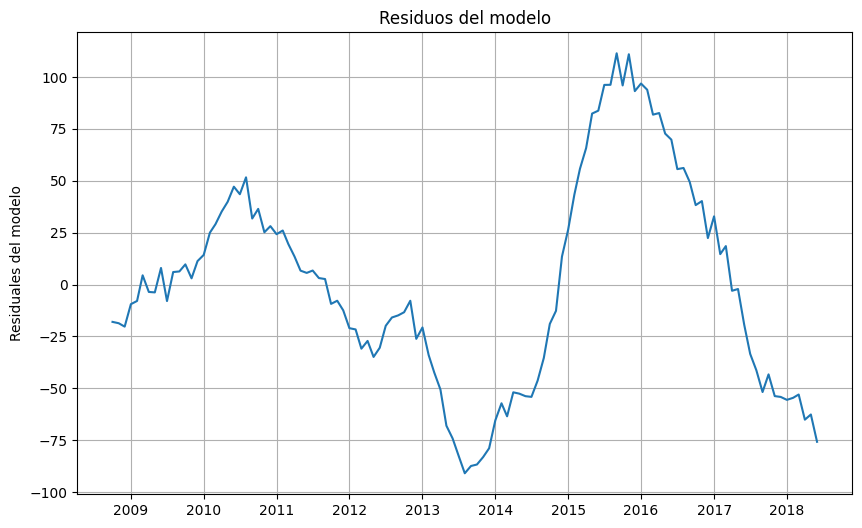

Serie original y tendencia ajustada:


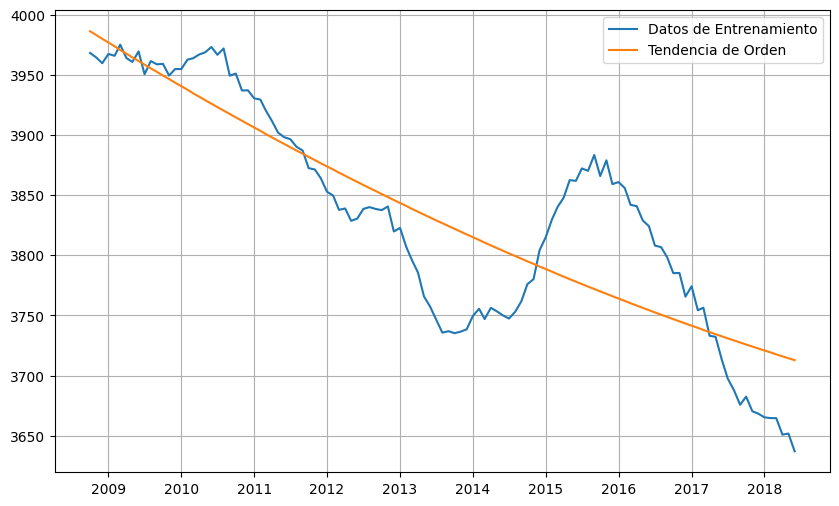

Pronóstico para los próximos 1 periodos:
   Point_forecast     Lower_95     Upper_95
0     3711.295501  3607.620295  3814.970706
Serie original y pronóstico estimado para los próximos 1 periodos:


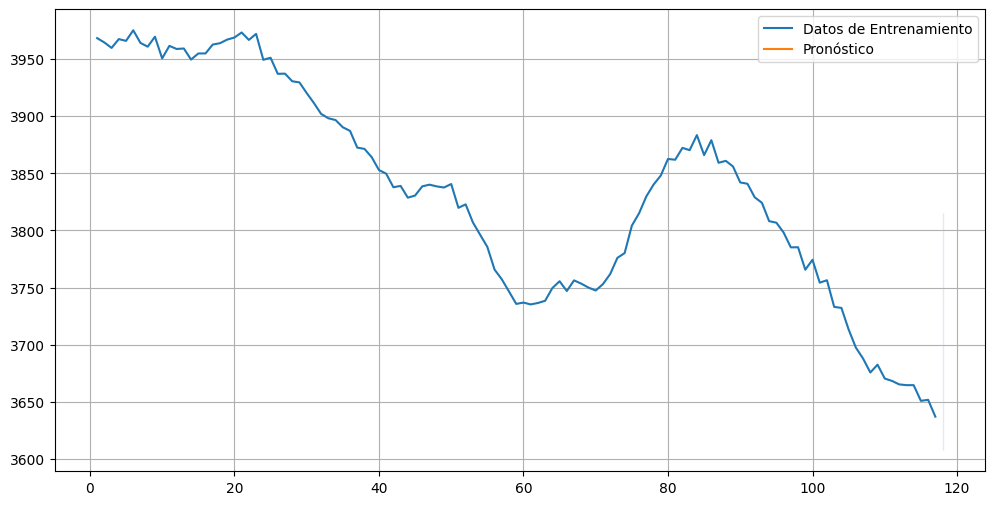

Zoom en los últimos 5 meses:


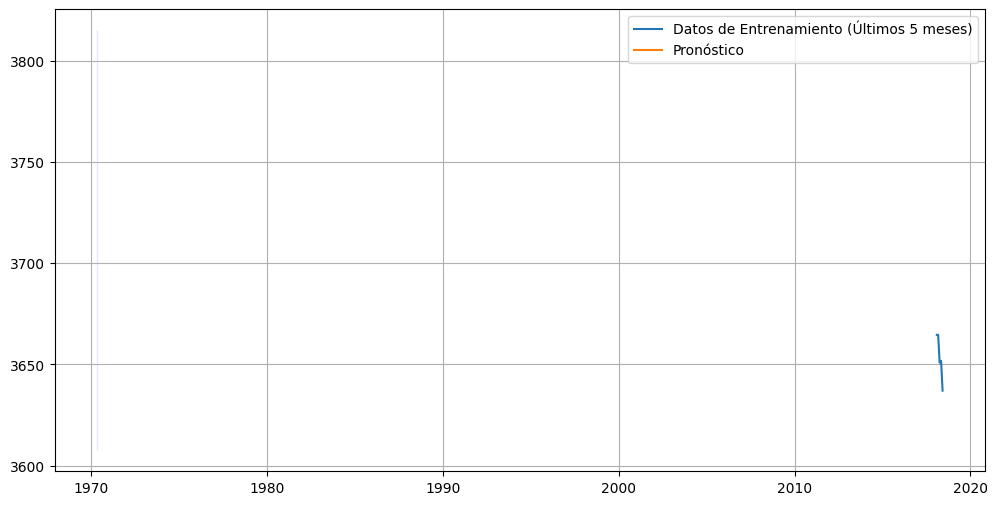

Resumen de RMSE por modelo:
Iteración 1: RMSE = 87.76447218123894
Iteración 2: RMSE = 93.56651033743219
Iteración 3: RMSE = 88.64084747948618
Iteración 4: RMSE = 85.29872827057352
Iteración 5: RMSE = 79.36312810284335
Iteración 6: RMSE = 73.17192109994221
Iteración 7: RMSE = 81.08913607449813
Iteración 8: RMSE = 73.28662150354921
Iteración 9: RMSE = 81.51681533972533
Iteración 10: RMSE = 69.30462784397787 <- Mejor modelo


In [90]:
# Ejecutar el proceso de evaluación con ventana móvil
test_errors, forecasts, best_model_summary = rolling_window_evaluation_poly(
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    order=2  
)

# Mostrar los resultados del mejor modelo encontrado
display_results(best_model_summary, test_errors)

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionSeasonalModel:
    def __init__(self, endog, degree, seasonal_periods):
        self.endog = endog
        self.degree = degree  # Degree of the polynomial
        self.seasonal_periods = seasonal_periods  # Number of seasonal periods
        self.model = None  # This will store the LinearRegression model
        self.poly = PolynomialFeatures(degree=self.degree)
        self.fittedvalues = None
        self.seasonal_dummies = pd.get_dummies(np.arange(self.seasonal_periods) % self.seasonal_periods, drop_first=False)

    def _create_design_matrix(self, y_train, future_steps=None):
        if future_steps is None:
            time_index = np.arange(len(y_train)).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(y_train)) % self.seasonal_periods, drop_first=False)
        else:
            time_index = np.arange(len(self.endog), len(self.endog) + future_steps).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(self.endog), len(self.endog) + future_steps) % self.seasonal_periods, drop_first=False)

        poly_features = self.poly.fit_transform(time_index)

        seasonality = seasonality.reindex(columns=self.seasonal_dummies.columns, fill_value=0)

        X = np.hstack([poly_features, seasonality])

        return X

    def fit(self):
        # Create the design matrix for the training data
        X_train = self._create_design_matrix(self.endog)

        # Fit the polynomial regression model
        self.model = LinearRegression().fit(X_train, self.endog)
        
        # Store the fitted values
        self.fittedvalues = pd.Series(self.model.predict(X_train), index=self.endog.index)

        return self

    def forecast(self, steps):
        # Create the design matrix for the future steps
        X_future = self._create_design_matrix(self.endog, future_steps=steps)

        # Forecast the next steps
        forecast_values = self.model.predict(X_future)

        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))

In [128]:
best_polynomial_forecasts = []
lower_RMSE = None

for i in range(1, 6):
	print(f"Polynomial of degree {i}")
	polynomial_test_errors, polynomial_forecasts, polynomial_model = rolling_window_evaluation(
		model_class=PolynomialRegressionSeasonalModel,
		data=data,
		target_column='producto1',
		initial_train_size=train_size,
		num_iterations=iterations,
		forecast_horizon=horizon,
		init_args={
			'degree': i,
			'seasonal_periods': 12
		}
	)
	polynomial_rmse = np.sqrt(np.mean(polynomial_test_errors))
	lower_RMSE = polynomial_rmse if lower_RMSE is None else min(lower_RMSE, polynomial_rmse)
	if polynomial_rmse == lower_RMSE:
		best_polynomial_forecasts = polynomial_forecasts
	print(f"Polynomial RMSE: {polynomial_rmse}")

Polynomial of degree 1
Polynomial RMSE: 56.8881306852753
Polynomial of degree 2
Polynomial RMSE: 87.10372887454567
Polynomial of degree 3
Polynomial RMSE: 66.82252082071234
Polynomial of degree 4
Polynomial RMSE: 68.68233596276532
Polynomial of degree 5
Polynomial RMSE: 99.05534481847937


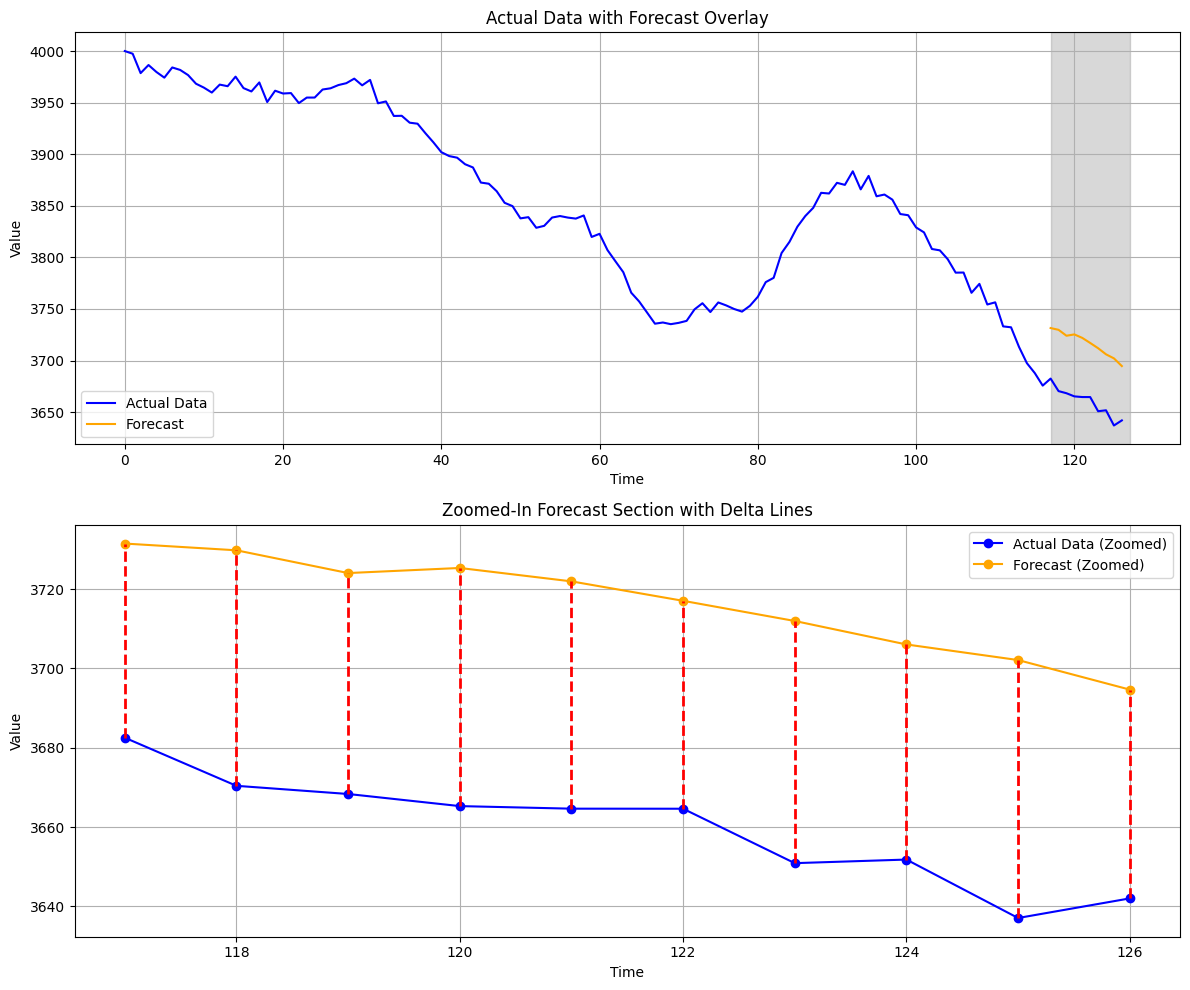

In [127]:
plot_forecast(data['producto1'], best_polynomial_forecasts, train_size)